<a href="https://colab.research.google.com/github/daniel-falk/ai-ml-principles-exercises/blob/main/ML-inference/ML-APIs/aws_rekognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Photo classification and face detection with API
This example shows how the machine learning API in Amazon Web Services can be used to analyze the content in the images.

The AWS API is a paid for API, in order to run the code you need to sign up for an AWS account and place your credentials in the `aws` file.

The python library used to communicate with the API is `boto3`, for other languages there are other libraries.

In [1]:
!pip install boto3

import json
import boto3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
aws_keys = json.load(open("aws"))

In [3]:
# Download an image we will send to the API
!wget https://www.nestle.se/sites/g/files/pydnoa401/files/styles/banner_image_slider_style/public/People-and-Culture---new-resolution.jpg -O faces.jpg

--2022-11-16 12:27:10--  https://www.nestle.se/sites/g/files/pydnoa401/files/styles/banner_image_slider_style/public/People-and-Culture---new-resolution.jpg
Resolving www.nestle.se (www.nestle.se)... 104.18.26.117, 104.18.27.117, 2606:4700::6812:1a75, ...
Connecting to www.nestle.se (www.nestle.se)|104.18.26.117|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 117419 (115K) [image/jpeg]
Saving to: ‘faces.jpg’

faces.jpg           100%[===================>] 114.67K  --.-KB/s    in 0.1s    

2022-11-16 12:27:12 (788 KB/s) - ‘faces.jpg’ saved [117419/117419]



# Find objects and faces
We will send the image to two different API endpoints, first one to find objects and put some general labels on the image, then one for face detection and analysis.

In [4]:
rekogn = boto3.client('rekognition', region_name="eu-west-1", aws_access_key_id=aws_keys["key"], aws_secret_access_key=aws_keys["secret"])

In [5]:
with open("faces.jpg", "rb") as f:
  file_content = f.read()

response = rekogn.detect_labels(
    Image={"Bytes": file_content},
    MaxLabels=30, MinConfidence=70
)
objects = response["Labels"]

In [6]:
object_types = [obj["Name"] for obj in objects]
object_types

['Groupshot',
 'Person',
 'Woman',
 'Adult',
 'Female',
 'Man',
 'Male',
 'Head',
 'Face',
 'People',
 'Happy',
 'Celebrating',
 'Coat',
 'Clothing']

In [7]:
categories = ["Colors and Visual Composition", "Expressions and Emotions", "Actions"]
obj_to_print = [obj for obj in objects if any([cat["Name"] in categories for cat in obj["Categories"]])]

for obj in obj_to_print:
  print("")
  print(f"{obj['Name']} ({obj['Categories'][0]['Name']})")
  print(f"Confidence: {obj['Confidence']:.2f}%")


Groupshot (Colors and Visual Composition)
Confidence: 99.60%

Happy (Expressions and Emotions)
Confidence: 87.61%

Celebrating (Actions)
Confidence: 82.85%


In [8]:
response = rekogn.detect_faces(
    Image={"Bytes": file_content},
    Attributes=['ALL']
)
faces = response["FaceDetails"]

In [9]:
faces[0].keys()

dict_keys(['BoundingBox', 'AgeRange', 'Smile', 'Eyeglasses', 'Sunglasses', 'Gender', 'Beard', 'Mustache', 'EyesOpen', 'MouthOpen', 'Emotions', 'Landmarks', 'Pose', 'Quality', 'Confidence'])

# Show the faces on the image
The face detection returns extensive information about the faces in the image. We are not going to visualize everything, but we will draw bounding boxes on the frame and print the estimated age range and the persons top emotion.

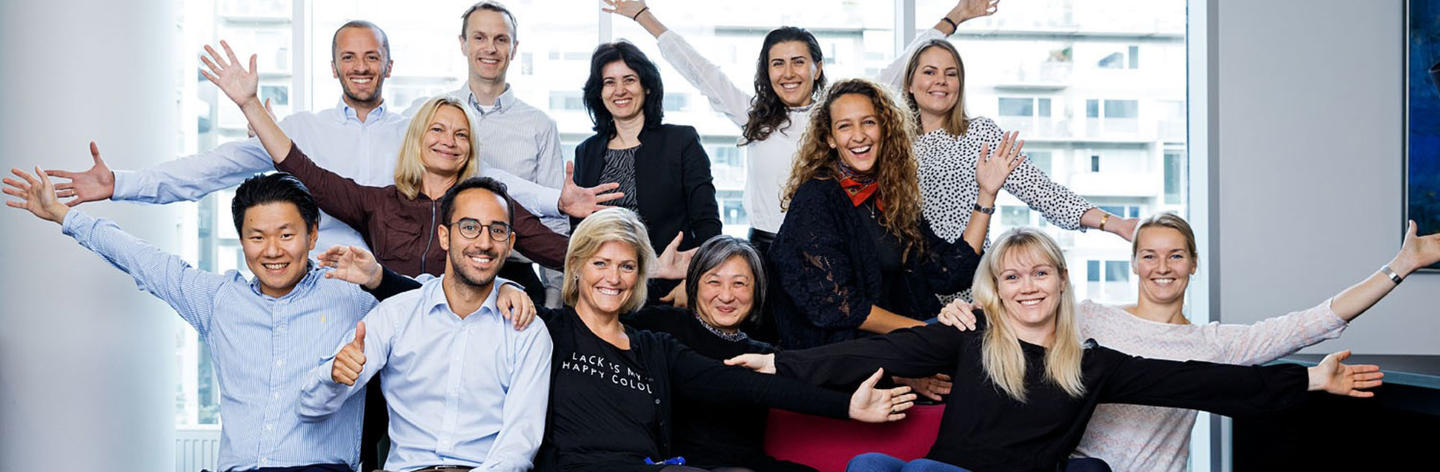

In [10]:
from PIL import Image, ImageDraw

img = Image.open("faces.jpg")
img_draw = ImageDraw.Draw(img)  
img

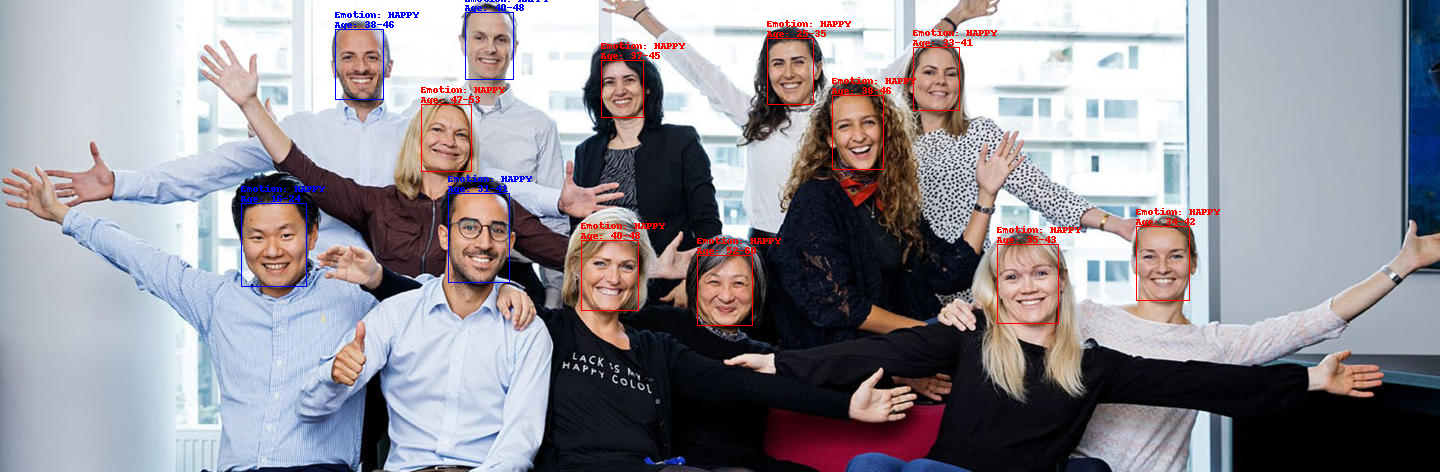

In [11]:
def instance_to_points(instance):
  obj = instance["BoundingBox"]
  w, h = img.size
  p0 = obj["Left"] * w, obj["Top"] * h
  p1 = (obj["Left"] + obj["Width"]) * w, (obj["Top"] + obj["Height"]) * h
  return p0, p1

for face in faces:
  color = "blue" if face["Gender"]["Value"] == "Male" else "red"
  pos = instance_to_points(face)
  img_draw.rectangle(pos, outline=color)
  # Write the age range
  img_draw.text(
      (pos[0][0], pos[0][1] - 10),
      f"Age: {face['AgeRange']['Low']}-{face['AgeRange']['High']}",
      fill=color,
  )
  # Write the top emotion
  emotion = sorted(face["Emotions"], key=lambda e: e["Confidence"], reverse=True)[0]["Type"]
  img_draw.text(
      (pos[0][0], pos[0][1] - 20),
      f"Emotion: {emotion}",
      fill=color,
  )
img

In [12]:
# Write all emotions for the first person
for emotion in sorted(faces[0]["Emotions"], key=lambda e: e["Confidence"], reverse=True):
  print(f"{emotion['Type']}: {emotion['Confidence']:.0f}%")

HAPPY: 99%
SURPRISED: 7%
FEAR: 6%
SAD: 2%
ANGRY: 0%
DISGUSTED: 0%
CONFUSED: 0%
CALM: 0%
